In [1]:
from glob import glob
import nibabel as nib
import numpy as np
import pandas as pd
import os

import seaborn as sns
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from brainspace.plotting import plot_hemispheres
from brainstat.stats.SLM import SLM
from brainstat.stats.terms import FixedEffect

import sys
from brainspace.mesh.mesh_io import read_surface
sys.path.insert(1, '/home/stevelab/hippunfold_toolbox')
from hippunfold_toolbox import plotting
import importlib
importlib.reload(plotting)

<module 'hippunfold_toolbox.plotting' from '/home/stevelab/hippunfold_toolbox/hippunfold_toolbox/plotting.py'>

In [2]:
hippunfold_dir1 = '/media/stevelab/DATA/FinalResultsLeftMerge/hippunfold'

surface_path = '"/media/stevelab/DATA/FinalResultsRightMerge/hippunfold/sub-002/surf/sub-002_hemi-R_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii"'
flatmap_path = '/home/stevelab/hippunfold_toolbox/resources/unfold_template_hipp/tpl-avg_space-unfold_den-0p5mm_midthickness.surf.gii'

surface_path1 = '/home/stevelab/hippunfold_toolbox/resources/canonical_surfs/tpl-avg_space-canonical_den-0p5mm_label-hipp_midthickness.surf.gii'

subjects = [ sub.replace('sub-','') for sub in os.listdir(hippunfold_dir1) if 'sub-' in sub ]
hemi = ['L','R']
label = ['hipp']
density = '0p5mm'

output_dir = 'brainstat_tutorial_outputleft'
smooth_dir = os.path.join(output_dir,'smoothed')

os.makedirs(smooth_dir,exist_ok=True)

In [3]:
flatmappathright = "/media/stevelab/DATA/FinalResultsLeftMerge/hippunfold/sub-002/surf/sub-002_hemi-R_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii"
flatmappathleft = "/media/stevelab/DATA/FinalResultsLeftMerge/hippunfold/sub-002/surf/sub-002_hemi-L_space-unfolded_den-0p5mm_label-hipp_midthickness.surf.gii"

In [4]:
flatmap_left = read_surface(flatmappathleft)  # use this one for the left surface 
flatmapleft_gii = nib.load(flatmappathleft)

flatmap_right = read_surface(flatmappathright)  # use this one for the right surface 
flatmapright_gii = nib.load(flatmappathright)

In [5]:
subjects = [path.split('_')[0].replace('sub-','')  for path in os.listdir(hippunfold_dir1)]

In [7]:
sigma = 2 #Gaussian smoothing kernal sigma (mm)

for subject in subjects:
    for h in range(len(hemi)):
        for l in range(len(label)):
            cmd = f'wb_command -metric-smoothing '\
                f'{hippunfold_dir1}/sub-{subject}/surf/sub-{subject}_hemi-{hemi[h]}_space-T2w_den-{density}_label-{label[l]}_midthickness.surf.gii '\
                f'{hippunfold_dir1}/sub-{subject}/surf/sub-{subject}_hemi-{hemi[h]}_space-T2w_den-{density}_label-{label[l]}_thickness.shape.gii '\
                f'{sigma} '\
                f'{smooth_dir}/sub-{subject}_hemi-{hemi[h]}_space-T2w_den-{density}_label-{label[l]}_desc-smoothed_thickness.shape.gii'
            !{cmd}
            
#also tried 3mm and 1mm, 3 mm more signficance and 1mm less signficant clusters more conserved

In [8]:
# remove after tutorial the sub, Sub part confuses me but ask Mohamed tmr 
subjects1 = [path.split('_')[0].replace('sub-','Sub-')  for path in os.listdir(hippunfold_dir1)]

In [9]:
thick_dict = {'L':[], 'R': []}

for subject in subjects:
    for h in hemi:
        thick_dict[h].append(nib.load(
            f'{smooth_dir}/sub-{subject}_hemi-{h}_space-T2w_den-{density}_label-{label[0]}_desc-smoothed_thickness.shape.gii'
        ).darrays[0].data)

In [10]:
thickL = np.vstack(thick_dict['L'])
thickR = np.vstack(thick_dict['R'])
thickLR = np.hstack([thickL,thickR])

In [56]:
df = pd.read_csv(r'/home/stevelab/Desktop/MujtabaFinalLeftdata1.csv')

In [57]:
df.columns

Index(['ADNI ID', 'Scan notes', 'Bids number', 'Sex', 'Age', 'diagnostic',
       'MMSE', 'MoCA', 'ADAS11', 'ADAS13', 'RAVLT immediate',
       'RAVLT perc forgetting', 'METACALC', 'LHERCALC', 'LHIFCALC', 'RHERCALC',
       'RHIFCALC', 'Unnamed: 17'],
      dtype='object')

In [25]:
df['Bids number'] = df['Bids number'].str.strip()
df = df.set_index('Bids number').loc[subjects1].reset_index()

In [26]:
df.head().iloc[:,1:]

ADNI ID Scan notes Sex  Age diagnostic  MMSE  MoCA  ADAS11  ADAS13  \
0  941_S_6581       Good   F   74         CN  30.0  28.0    3.33    6.33   
1  941_S_6575       Good   M   73         CN  27.0  23.0    6.00   11.00   
2  941_S_6546       Good   F   80         CN  28.0  22.0    9.00   13.00   
3  941_S_6514       Good   F   74         CN  30.0  28.0    9.00   12.00   
4  941_S_6499       Good   F   69         CN  28.0  19.0    8.33   14.33   

   RAVLT immediate  RAVLT perc forgetting  METACALC  LHERCALC  LHIFCALC  \
0             60.0                7.14286  1.144619  1.121484  1.172748   
1             37.0               50.00000  1.182111  1.259514  1.170501   
2             28.0               71.42860  1.180117  1.170548  1.234024   
3             53.0                7.14286  1.117909  0.975941  1.132324   
4             36.0               60.00000  1.125430  1.065637  1.144214   

   RHERCALC  RHIFCALC Unnamed: 17  
0  1.146046  1.144925         NaN  
1  1.261772  1.150613         NaN  
2  1.111643  1.179160         NaN  
3  0.970652  1.143005         NaN  
4  1.059167  1.123865         NaN

In [58]:
df

ADNI ID Scan notes Bids number Sex  Age diagnostic  MMSE  MoCA  \
0    941_S_6581       Good     Sub-002   F   74         CN  30.0  28.0   
1    941_S_6575       Good     Sub-004   M   73         CN  27.0  23.0   
2    941_S_6546       Good     Sub-006   F   80         CN  28.0  22.0   
3    941_S_6514       Good     Sub-007   F   74         CN  30.0  28.0   
4    941_S_6499       Good     Sub-008   F   69         CN  28.0  19.0   
..          ...        ...         ...  ..  ...        ...   ...   ...   
519  129_S_6784       Good     Sub-929   M   83         AD  26.0  24.0   
520  130_S_6072       Good     Sub-930   F   89         AD  24.0  23.0   
521  135_S_6389       Good     Sub-938   M   70         AD  24.0  28.0   
522  135_S_6687       Good     Sub-940   F   80         AD  23.0  20.0   
523  135_S_6840       Good     Sub-941   F   69         AD  28.0  22.0   

     ADAS11  ADAS13  RAVLT immediate  RAVLT perc forgetting  METACALC  \
0      3.33    6.33             60.0                7.14286  1.144619   
1      6.00   11.00             37.0               50.00000  1.182111   
2      9.00   13.00             28.0               71.42860  1.180117   
3      9.00   12.00             53.0                7.14286  1.117909   
4      8.33   14.33             36.0               60.00000  1.125430   
..      ...     ...              ...                    ...       ...   
519    9.00   16.00             24.0              100.00000  1.250222   
520   24.33   36.33             31.0              100.00000  1.423419   
521    9.00   14.00             41.0               90.00000  1.250228   
522   21.67   31.67             27.0              100.00000  1.458071   
523   21.00   30.00             24.0              100.00000  1.968584   

     LHERCALC  LHIFCALC  RHERCALC  RHIFCALC Unnamed: 17  
0    1.121484  1.172748  1.146046  1.144925         NaN  
1    1.259514  1.170501  1.261772  1.150613         NaN  
2    1.170548  1.234024  1.111643  1.179160         NaN  
3    0.975941  1.132324  0.970652  1.143005         NaN  
4    1.065637  1.144214  1.059167  1.123865         NaN  
..        ...       ...       ...       ...         ...  
519  1.329973  1.246171  1.322957  1.293606         NaN  
520  1.628309  1.493837  1.592443  1.428773         NaN  
521  1.303863  1.299402  1.327284  1.258339         NaN  
522  1.647776  1.594103  1.630185  1.352124         NaN  
523  1.836992  1.937064  1.958910  2.134089         NaN  

[524 rows x 18 columns]

In [29]:
from brainstat.stats.terms import FixedEffect

term_age = FixedEffect(df.Age)
term_sex = FixedEffect(df.Sex)
term_group = FixedEffect(df.diagnostic)
term_metacalc = FixedEffect(df.METACALC)
term_lher = FixedEffect(df.LHERCALC)
term_rher = FixedEffect(df.RHERCALC)
term_lhif = FixedEffect(df.LHIFCALC)
term_rhif = FixedEffect(df.RHIFCALC)

#all our models are going to be one tailed with a negative contrast because we predict thickness to decrease as PET goes up

# METAROI Calculations

In [30]:
model_metacalc = term_sex + term_age + term_metacalc + term_age * term_sex + term_group
contrast_metacalc = df.METACALC

slm_metacalcleft = SLM(
    model_metacalc,
    -contrast_metacalc,
    flatmap_left,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
    )  
slm_metacalcleft.fit(thickL)  

In [31]:
slm_metacalcleft.P["clus"]

[   clusid  nverts    resels         P
 0       1  1920.0  4.733180  0.000003
 1       2   232.0  1.790048  0.005791
 2       3    36.0  0.272048  0.299726
 3       4    27.0  0.135954  0.404680
 4       5     1.0  0.035419  0.495883
 5       6    10.0  0.033675  0.497552
 6       7     1.0  0.002731  0.527570]

In [32]:
model_metacalc = term_sex + term_age + term_metacalc + term_age * term_sex + term_group
contrast_metacalc = df.METACALC

slm_metacalcright = SLM(
    model_metacalc,
    -contrast_metacalc,
    flatmap_right,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
    )  
slm_metacalcright.fit(thickR)  

In [33]:
slm_metacalcright.P["clus"]

[   clusid  nverts    resels         P
 0       1  1275.0  2.922636  0.000288
 1       2   174.0  1.060374  0.040007
 2       3   184.0  0.765926  0.086892
 3       4   119.0  0.626750  0.124471
 4       5    10.0  0.131332  0.404819]

In [34]:
def plot_surf(data, window=None, excludeDG=True, density='0p5mm'):
    if window == None:
        im = plt.imshow(data.reshape(-1,1).T);

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), subplot_kw={'projection': "3d"})
        fig.set_dpi(300)

        plotting.surfplot_canonical_foldunfold(ax,cdata=data,excludeDG=excludeDG,den=density)

        cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3])
        fig.colorbar(im, cax=cbar_ax);
        
    else:
        im = plt.imshow(data.reshape(-1,1).T,vmin=window[0],vmax=window[1]);

        fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8,8), subplot_kw={'projection': "3d"})
        fig.set_dpi(300)

        plotting.surfplot_canonical_foldunfold(ax,cdata=data,excludeDG=excludeDG,den=density, cwindow=window)

        cbar_ax = fig.add_axes([0.85, 0.35, 0.05, 0.3])
        fig.colorbar(im, cax=cbar_ax);

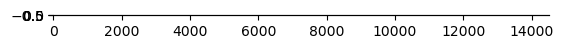

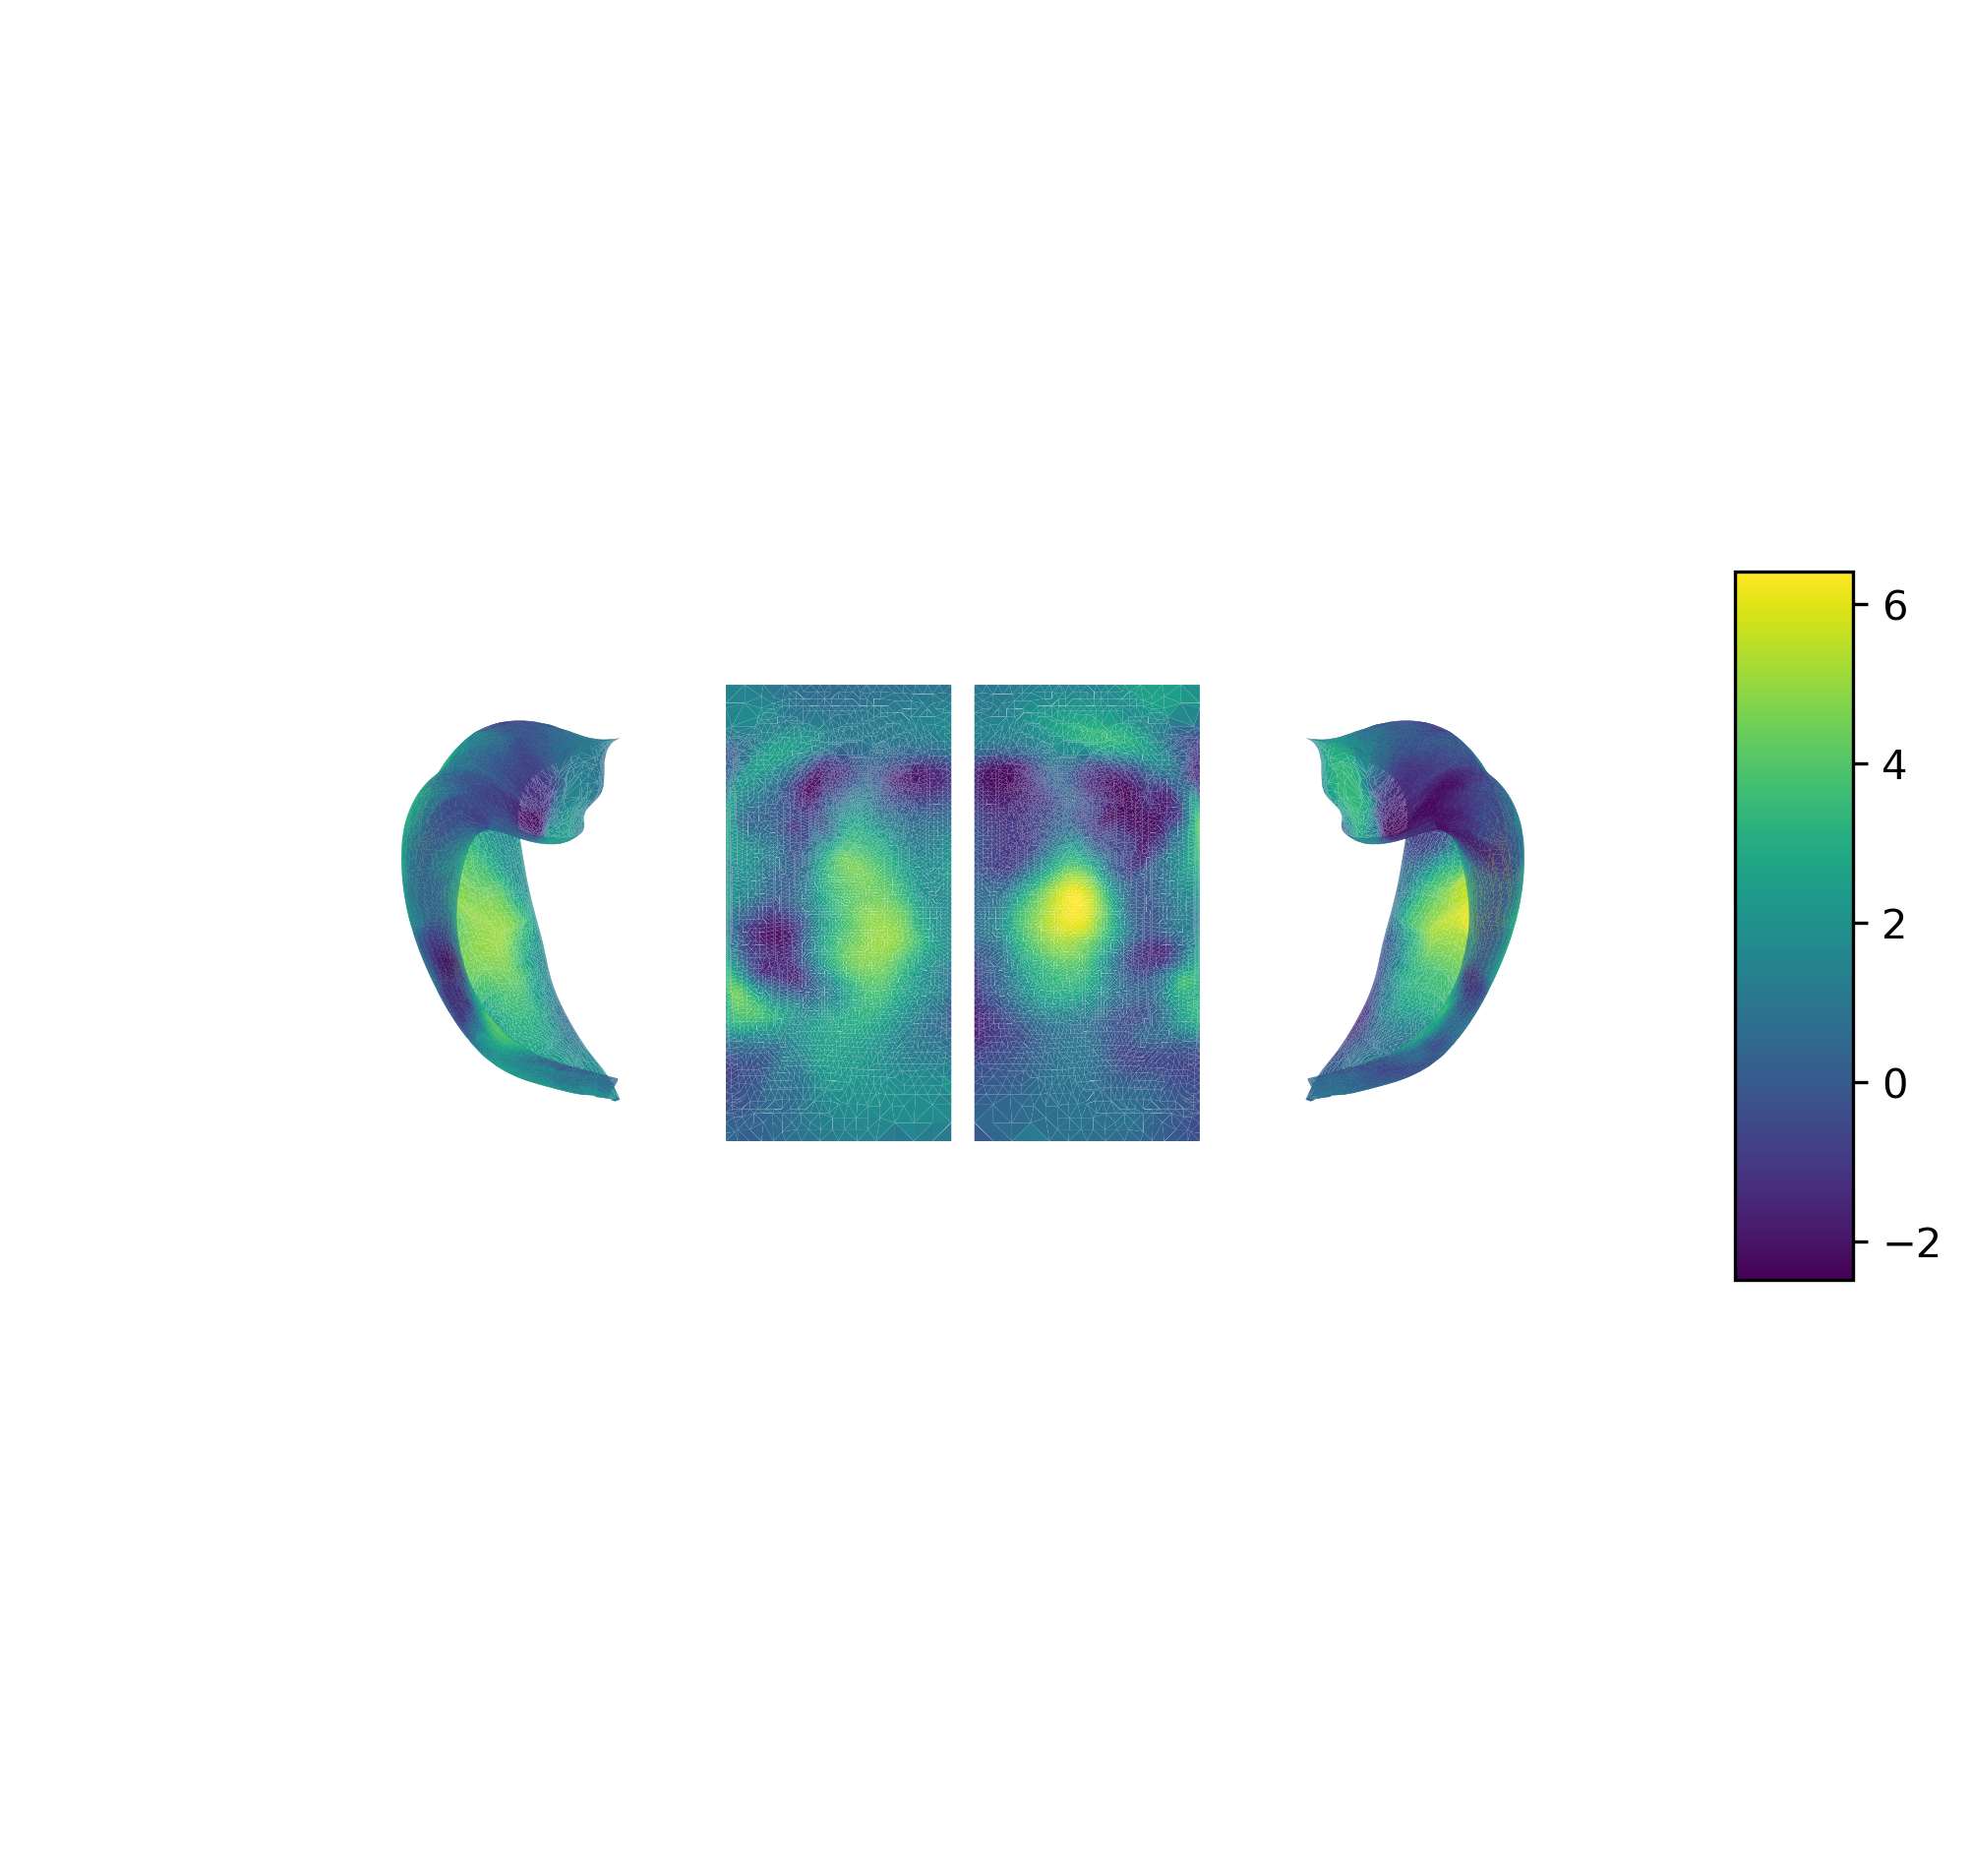

In [59]:
plot_surf(np.hstack([slm_metacalcleft.t,slm_metacalcright.t]).T)
#what exactly is this plotting?? not thickness cause that the other one? 

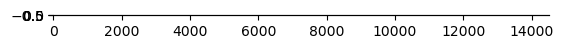

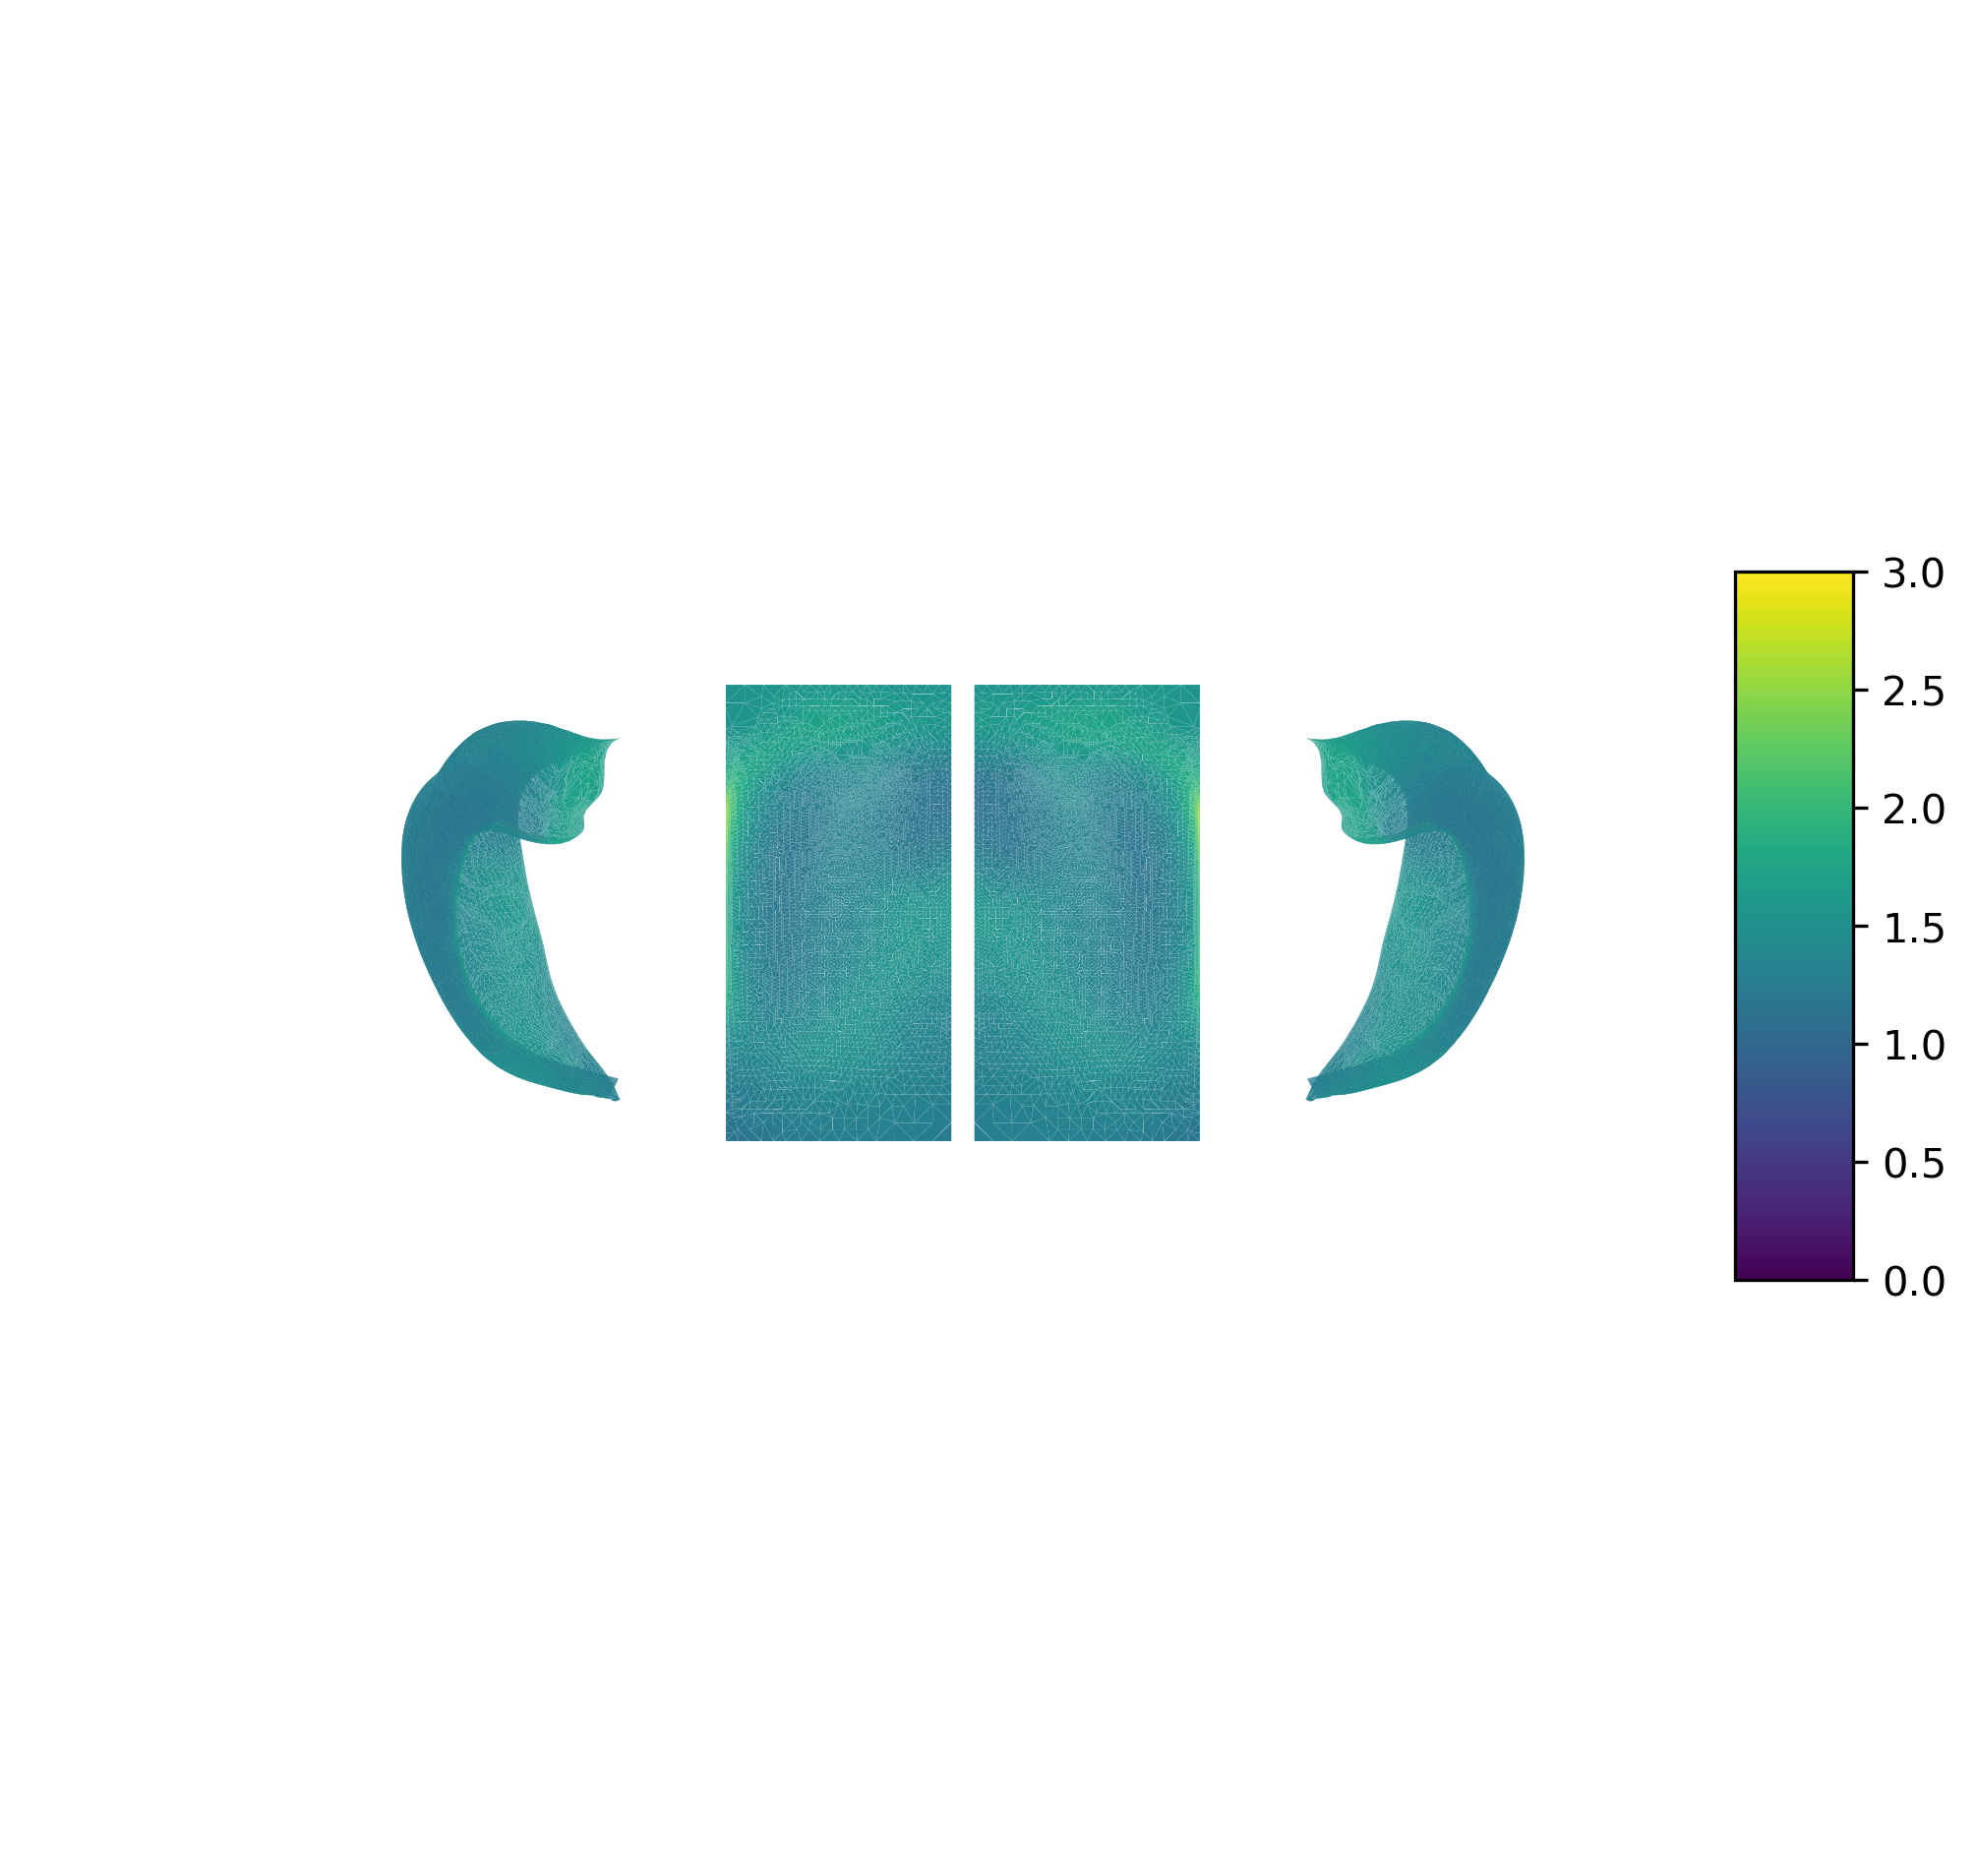

In [35]:
plot_surf(thickLR.mean(axis=0),window=[0,3])

In [36]:
peak_sigL = slm_metacalcleft.P['pval']['P']<0.05
peak_sigR = slm_metacalcright.P['pval']['P']<0.05
clus_sigL = slm_metacalcleft.P['pval']['C']<0.05
clus_sigR = slm_metacalcright.P['pval']['C']<0.05

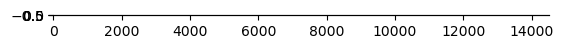

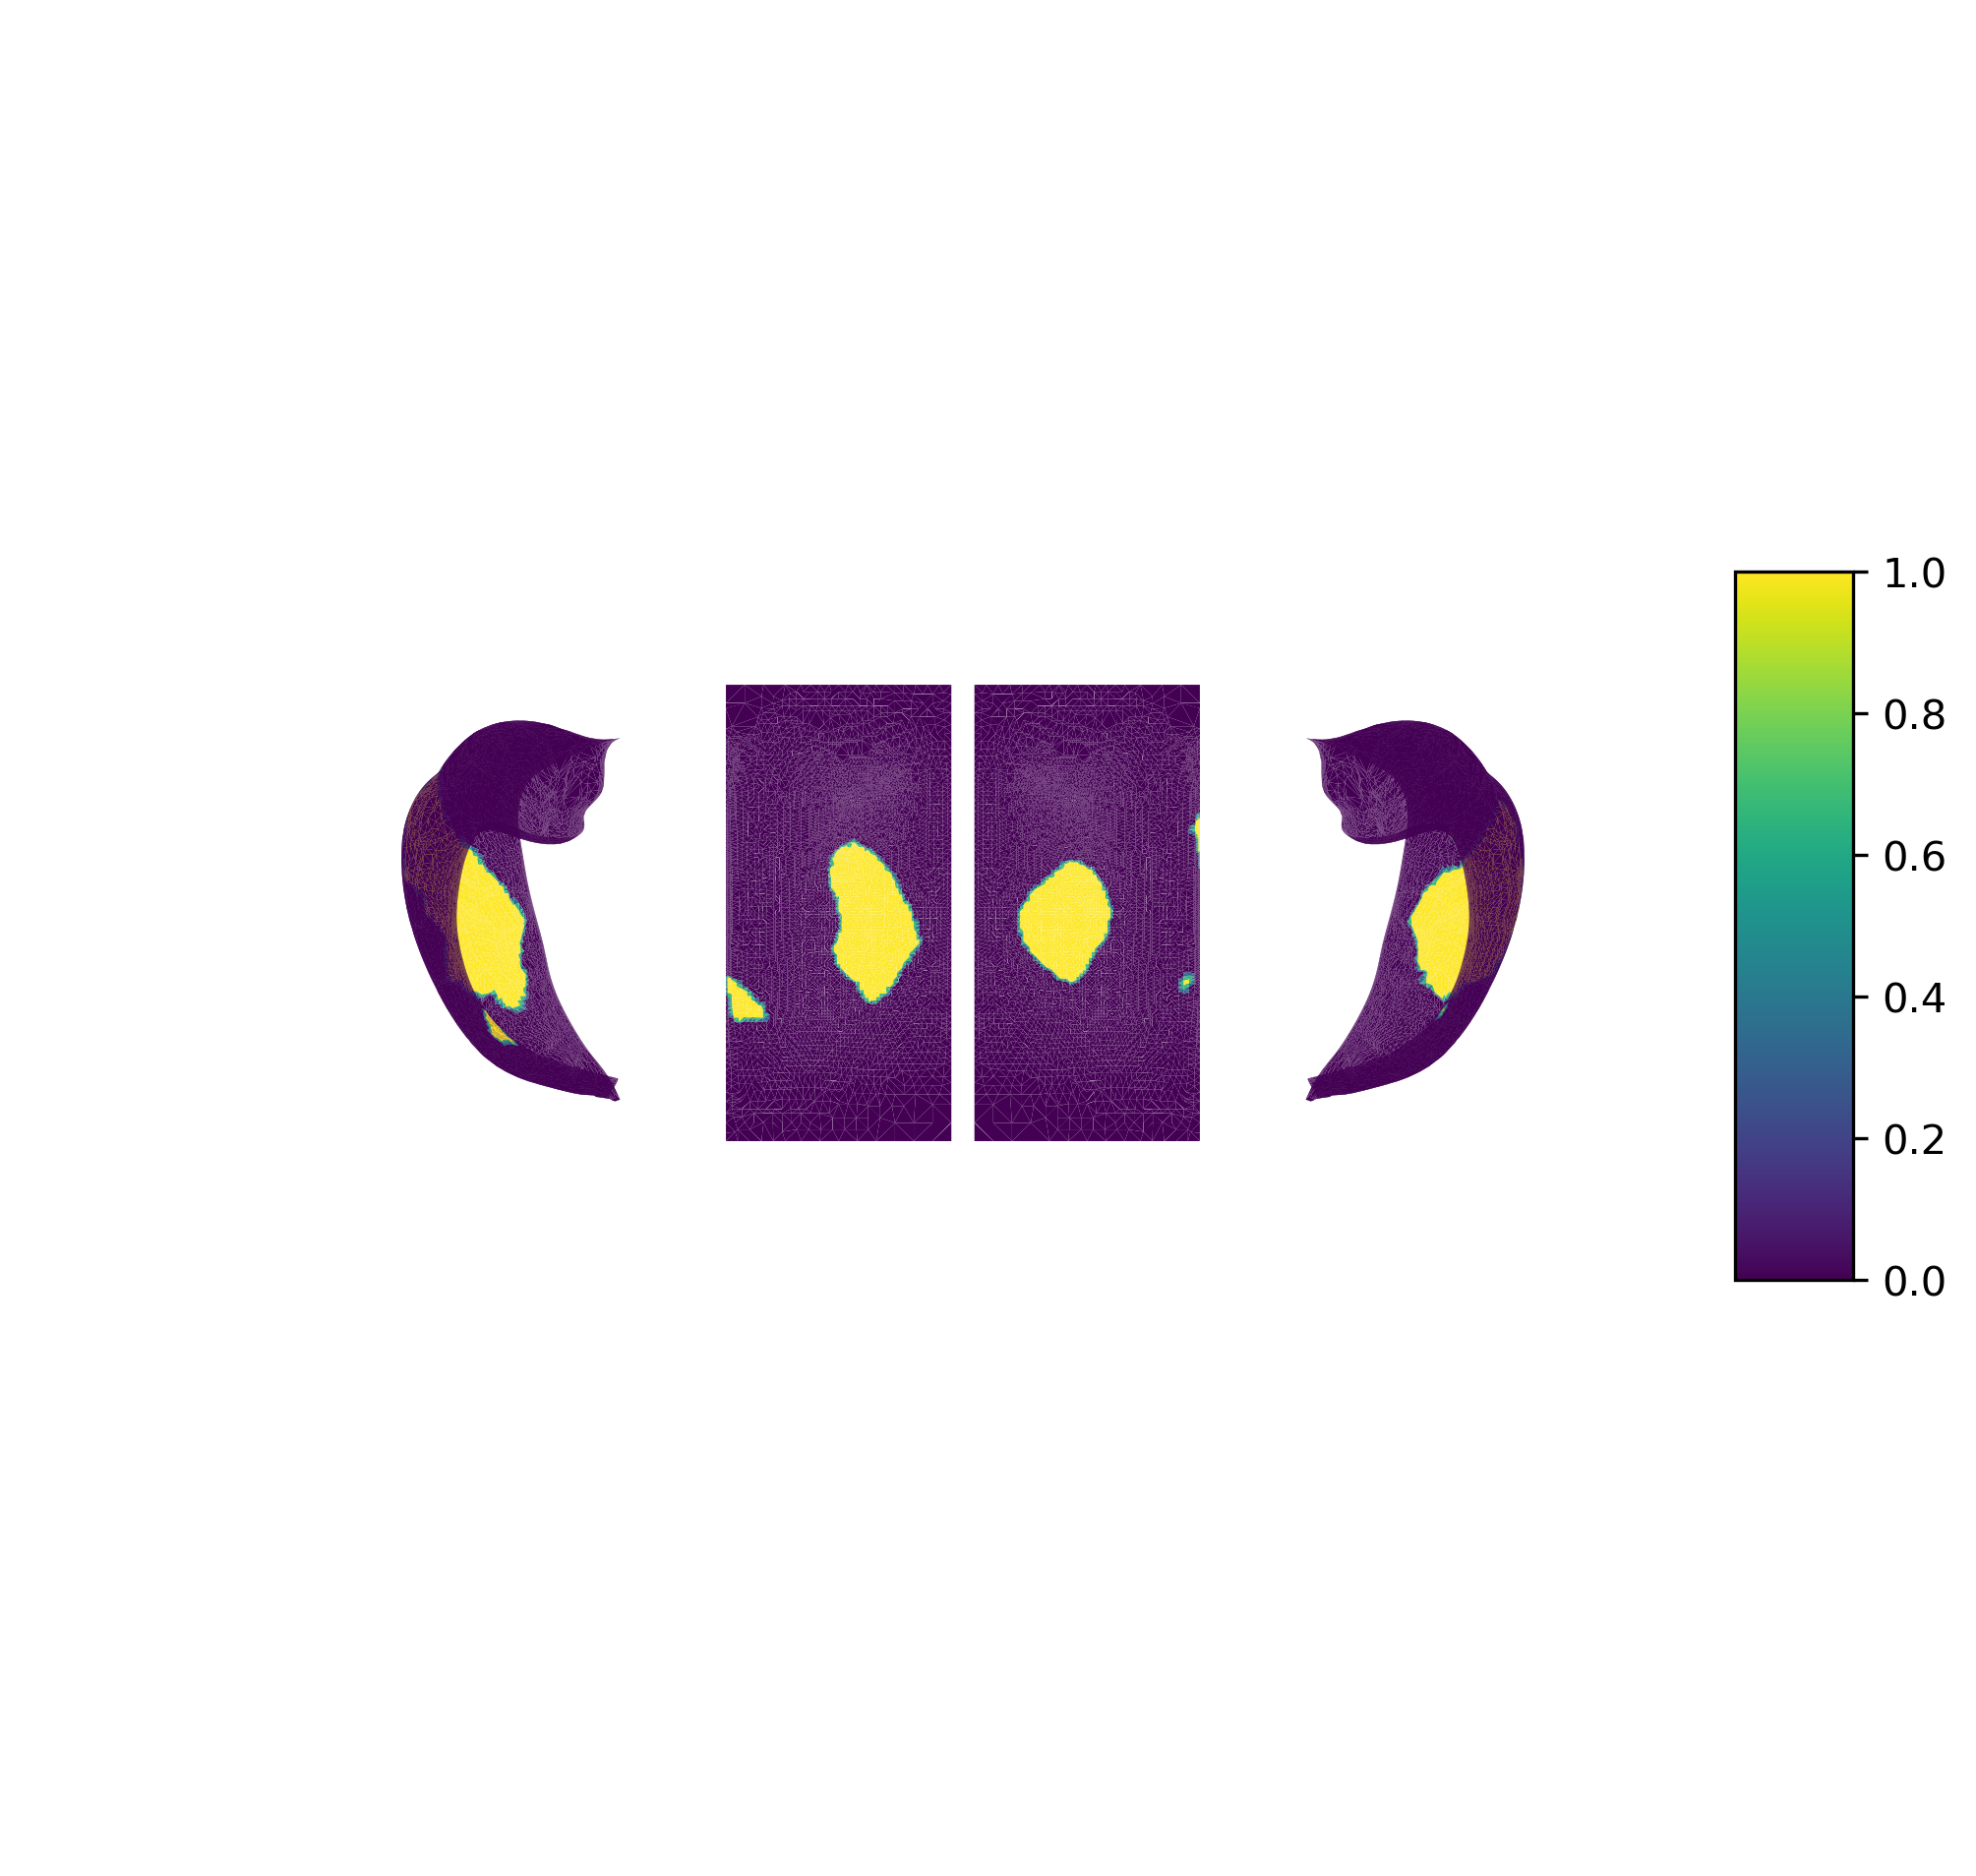

In [37]:
plot_surf(np.hstack([peak_sigL,peak_sigR]).T)

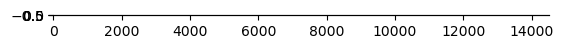

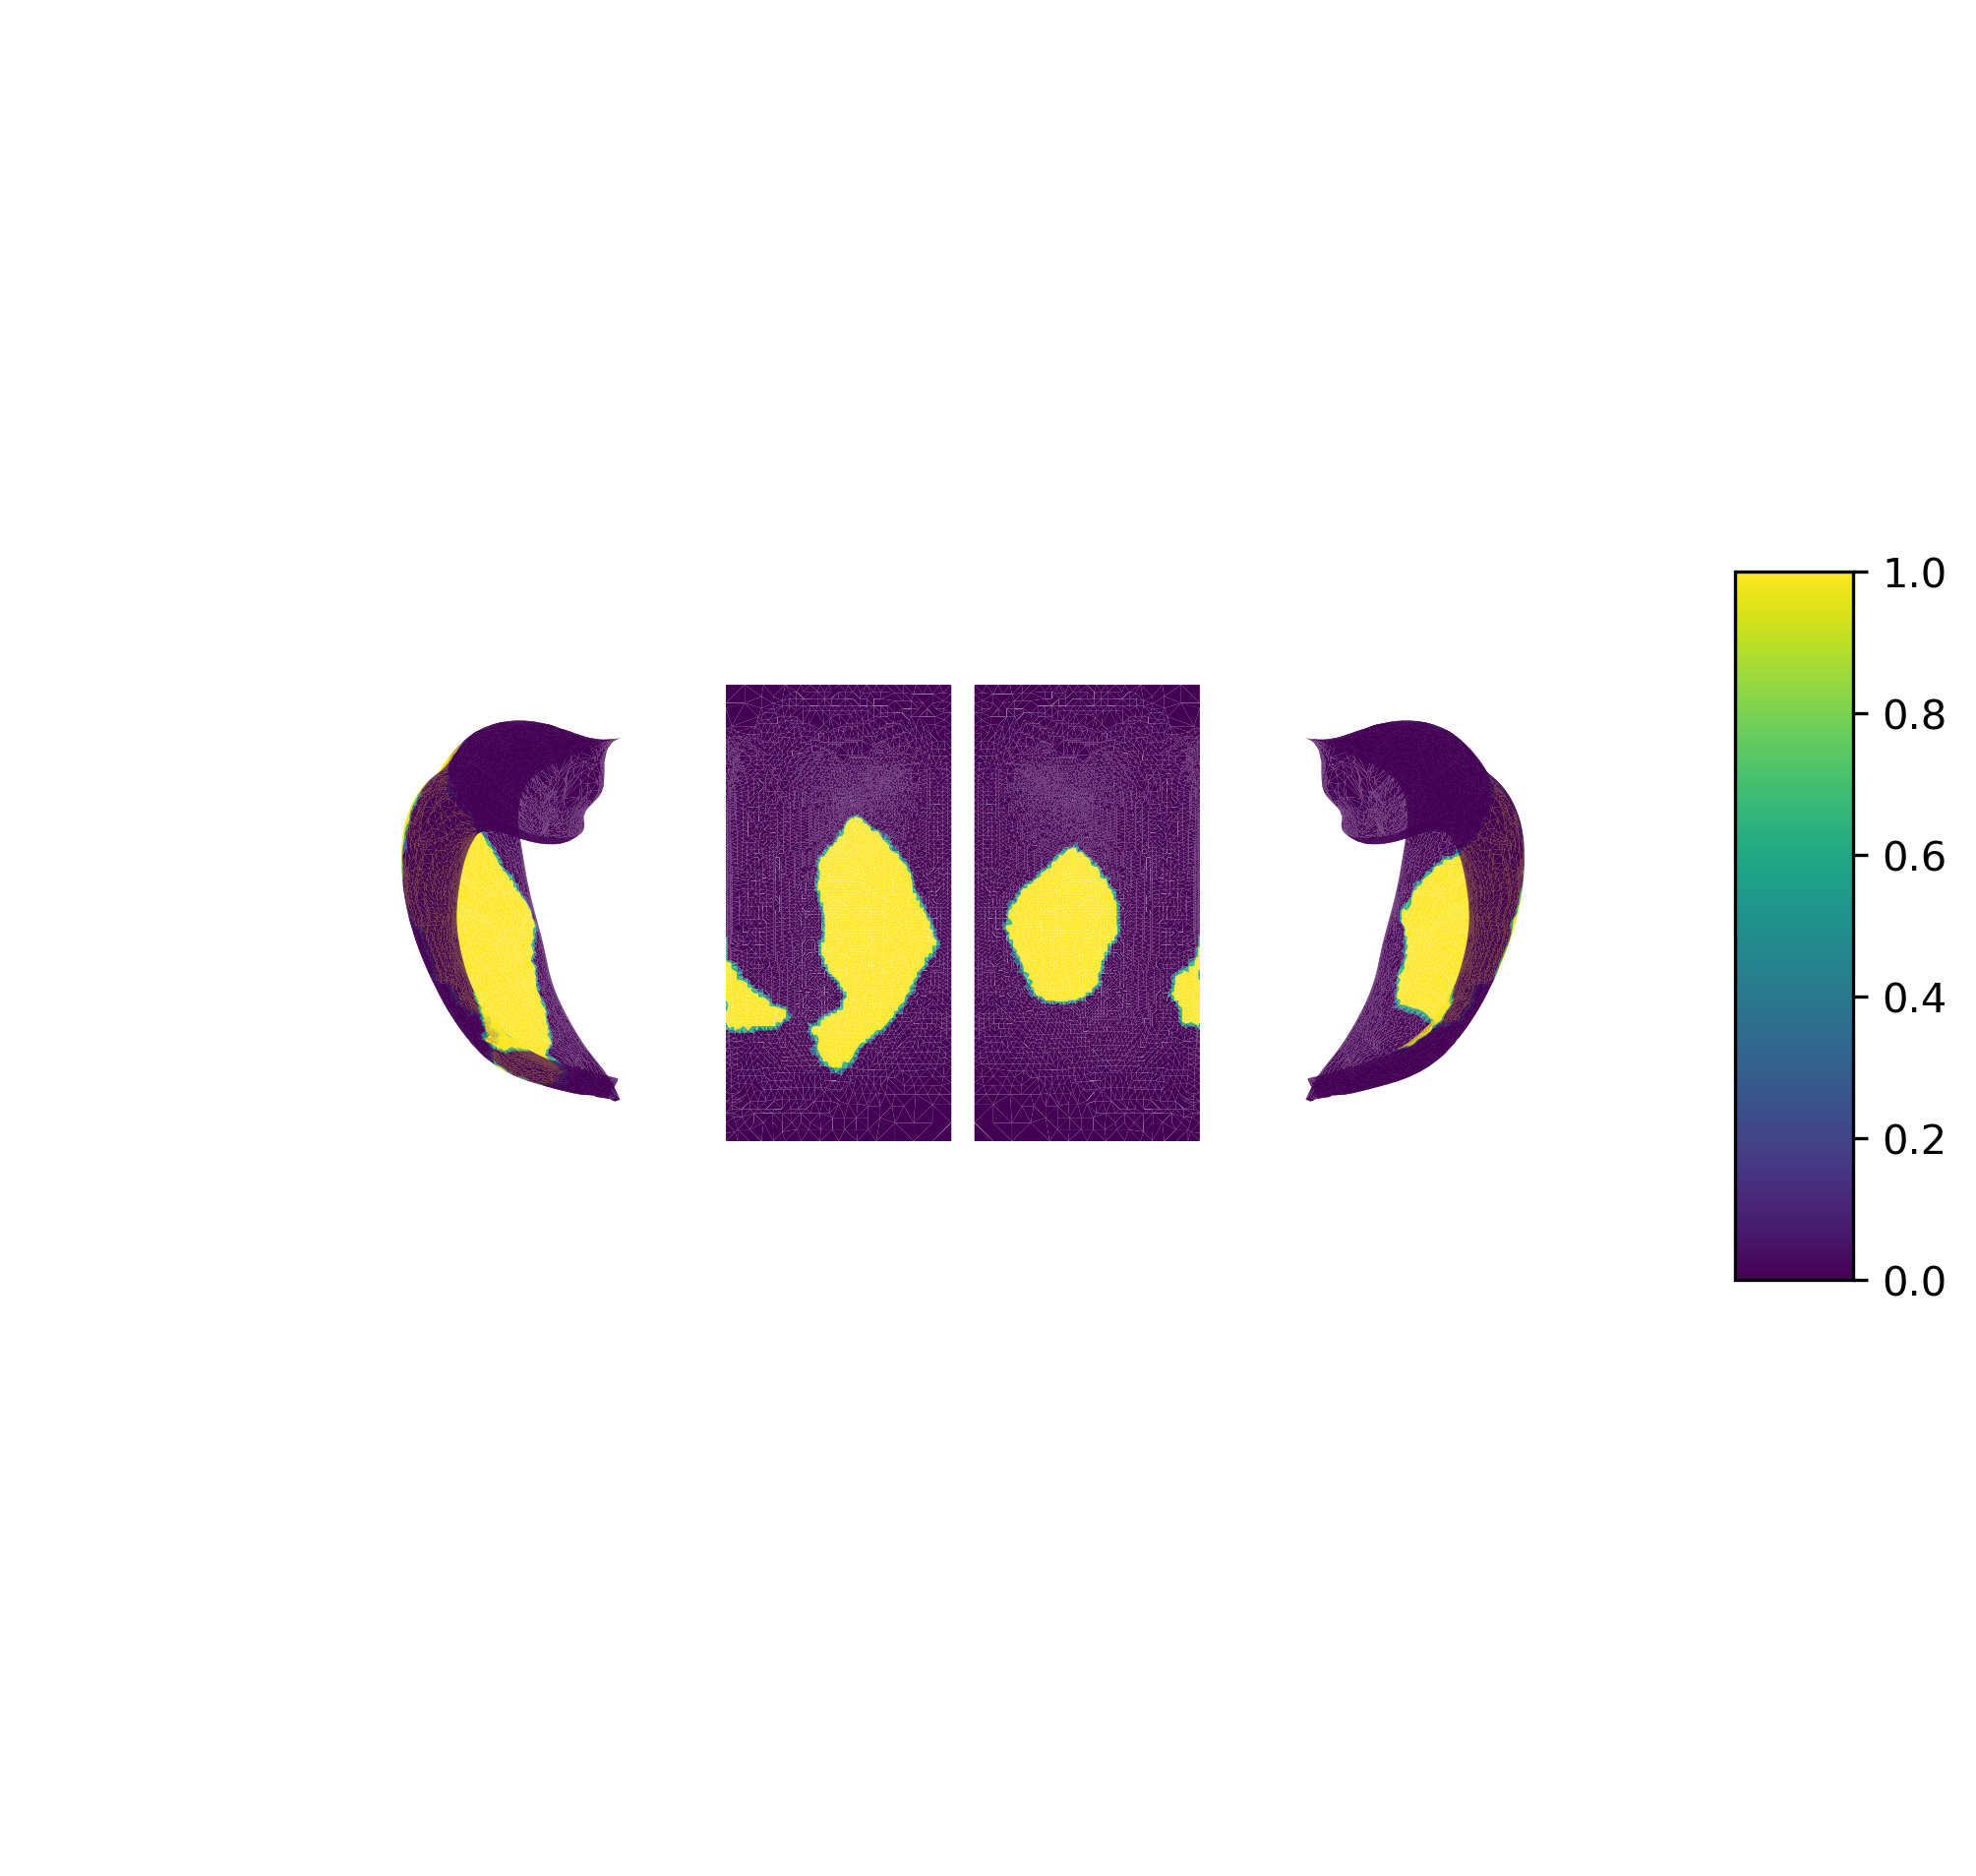

In [38]:
plot_surf(np.hstack([clus_sigL,clus_sigR]).T)

# Left Entorhinal Cortex Calculation 

In [42]:
model_lher = term_sex + term_age + term_age * term_sex + term_lher + term_group
contrast_lher = df.LHERCALC

slm_lher = SLM(
    model_lher,
    -contrast_lher,
    flatmap_left,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
    )  
slm_lher.fit(thickL)  

In [43]:
model_rher = term_sex + term_age + term_age * term_sex + term_rher + term_group
contrast_rher = df.RHERCALC

slm_rher = SLM(
    model_rher,
    -contrast_rher,
    flatmap_right,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
    )  
slm_rher.fit(thickR)  

In [44]:
slm_lher.P["clus"]

[   clusid  nverts    resels             P
 0       1  2506.0  6.353283  8.488071e-08
 1       2   203.0  1.711298  7.157730e-03
 2       3   201.0  1.290414  2.199870e-02
 3       4     3.0  0.008543  5.226737e-01]

In [45]:
peakrher_sigL = slm_lher.P['pval']['P']<0.05
peakrher_sigR = slm_rher.P['pval']['P']<0.05
clusrher_sigL = slm_lher.P['pval']['C']<0.05
clusrher_sigR = slm_rher.P['pval']['C']<0.05

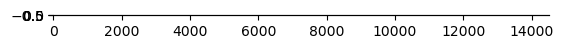

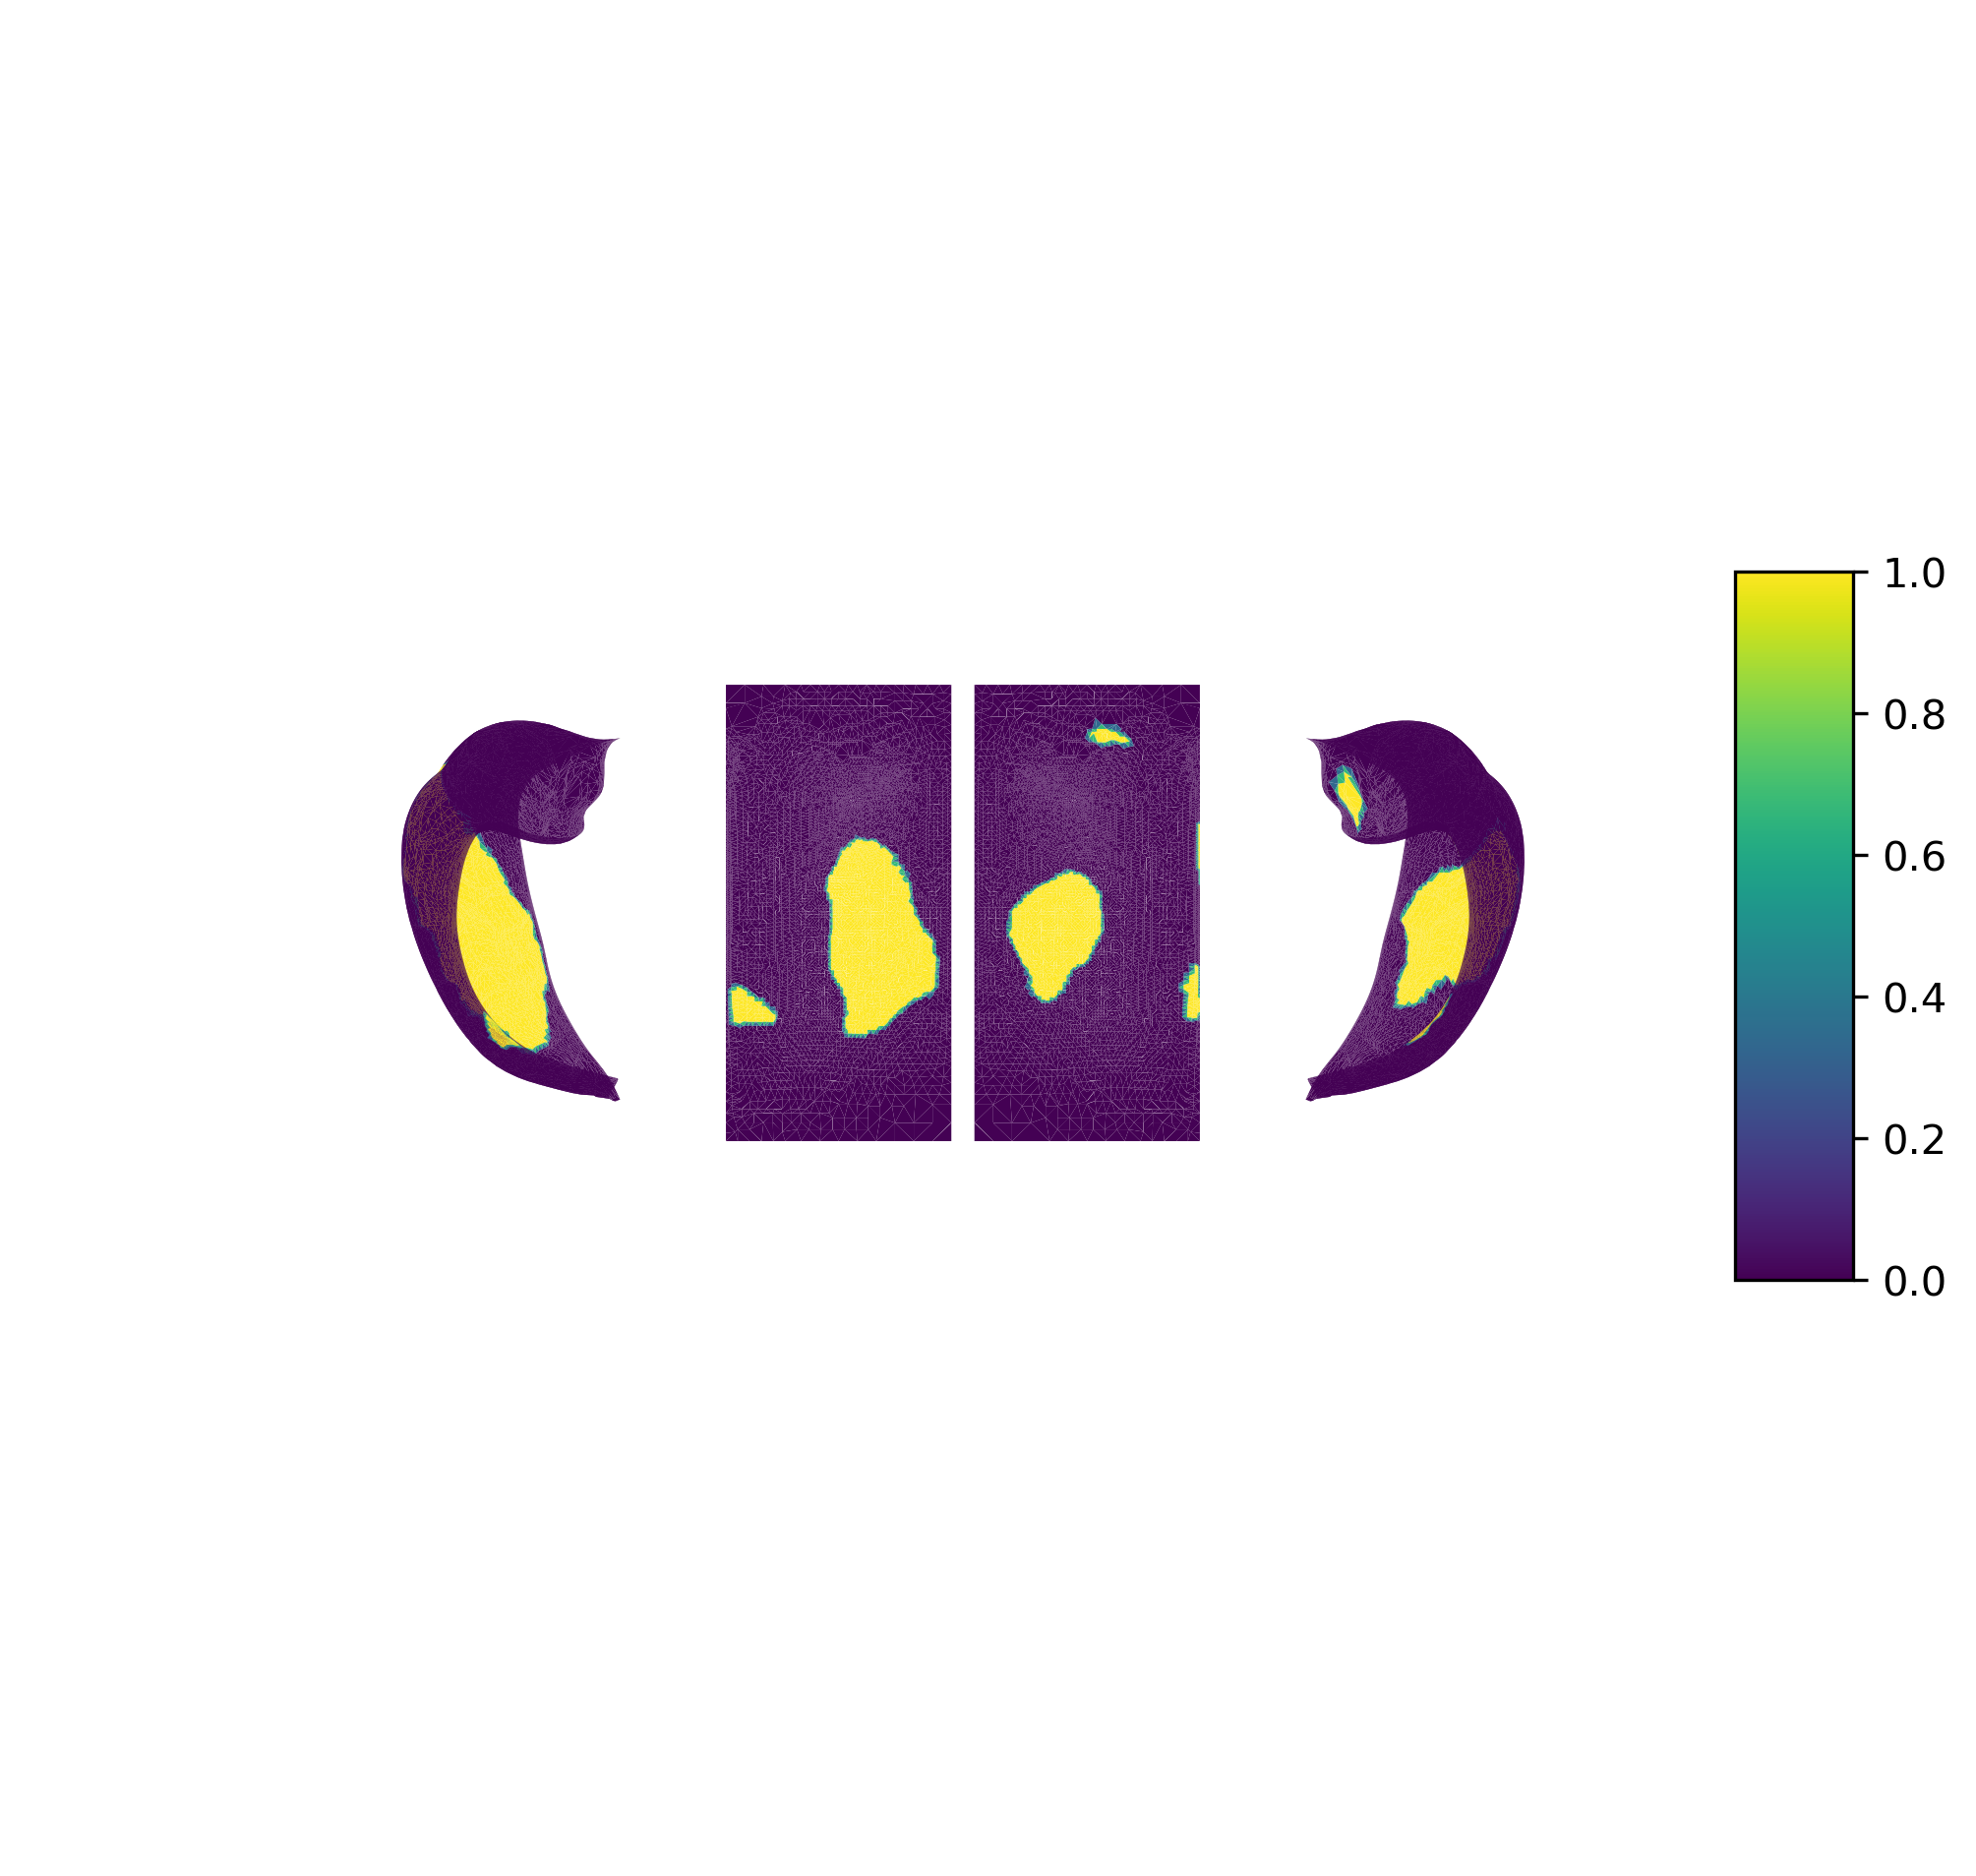

In [46]:
plot_surf(np.hstack([peakrher_sigL,peakrher_sigR]).T)

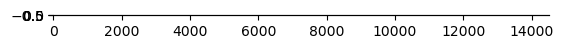

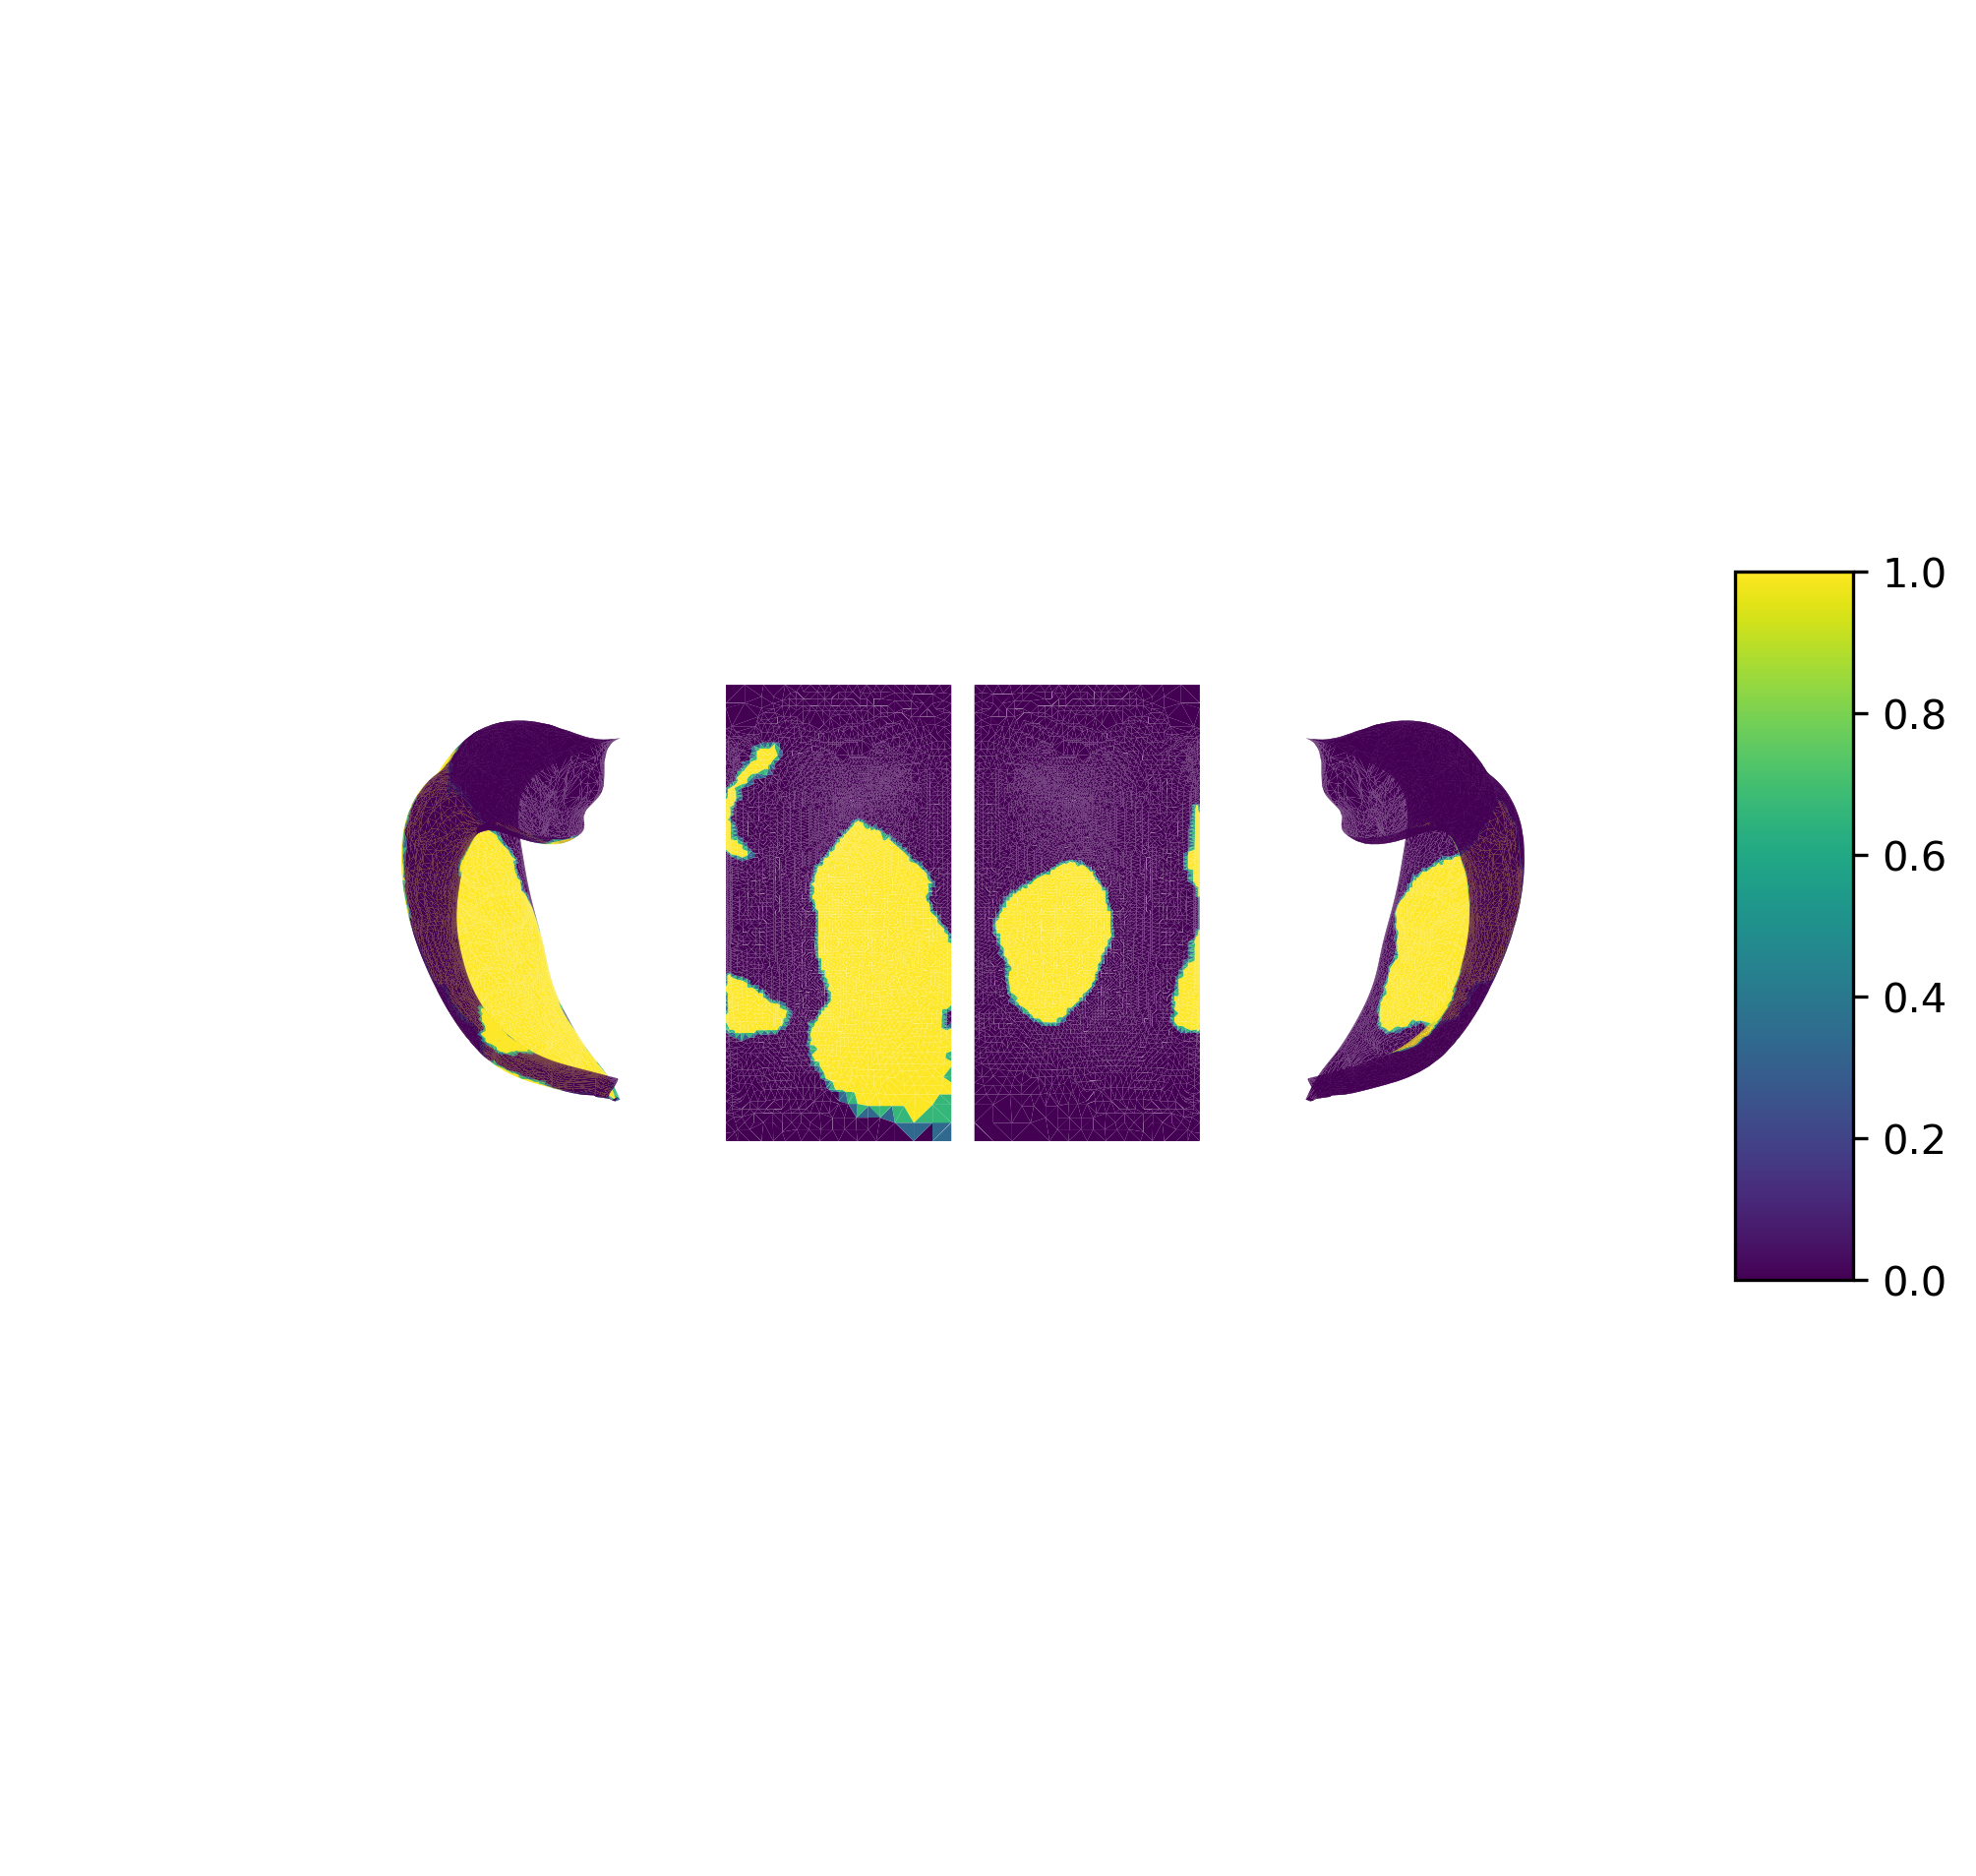

In [47]:
plot_surf(np.hstack([clusrher_sigL,clusrher_sigR]).T)

# Left Inferior Temporal Calculations 

In [50]:
model_lhif = term_sex + term_age + term_age * term_sex + term_lhif + term_group
contrast_lhif = df.LHIFCALC

slm_lhif = SLM(
    model_lhif,
    -contrast_lhif,
    flatmap_left,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
    )  
slm_lhif.fit(thickL) 

In [51]:
model_rhif = term_sex + term_age + term_age * term_sex + term_rhif + term_group
contrast_rhif = df.RHIFCALC

slm_rhif = SLM(
    model_rhif,
    -contrast_rhif,
    flatmap_right,
    correction=["fdr", "rft"],
    cluster_threshold=0.01,
    two_tailed=False,
    )  
slm_rhif.fit(thickR) 

In [52]:
slm_lhif.P["clus"]

[   clusid  nverts    resels         P
 0       1  1715.0  4.156048  0.000012
 1       2   178.0  1.437956  0.014793
 2       3   182.0  1.082682  0.038131
 3       4    11.0  0.036727  0.494327
 4       5     1.0  0.035399  0.495596]

In [53]:
peakif_sigL = slm_lhif.P['pval']['P']<0.05
peakif_sigR = slm_rhif.P['pval']['P']<0.05
clusif_sigL = slm_lhif.P['pval']['C']<0.05
clusif_sigR = slm_rhif.P['pval']['C']<0.05

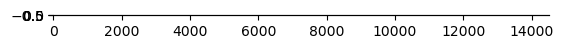

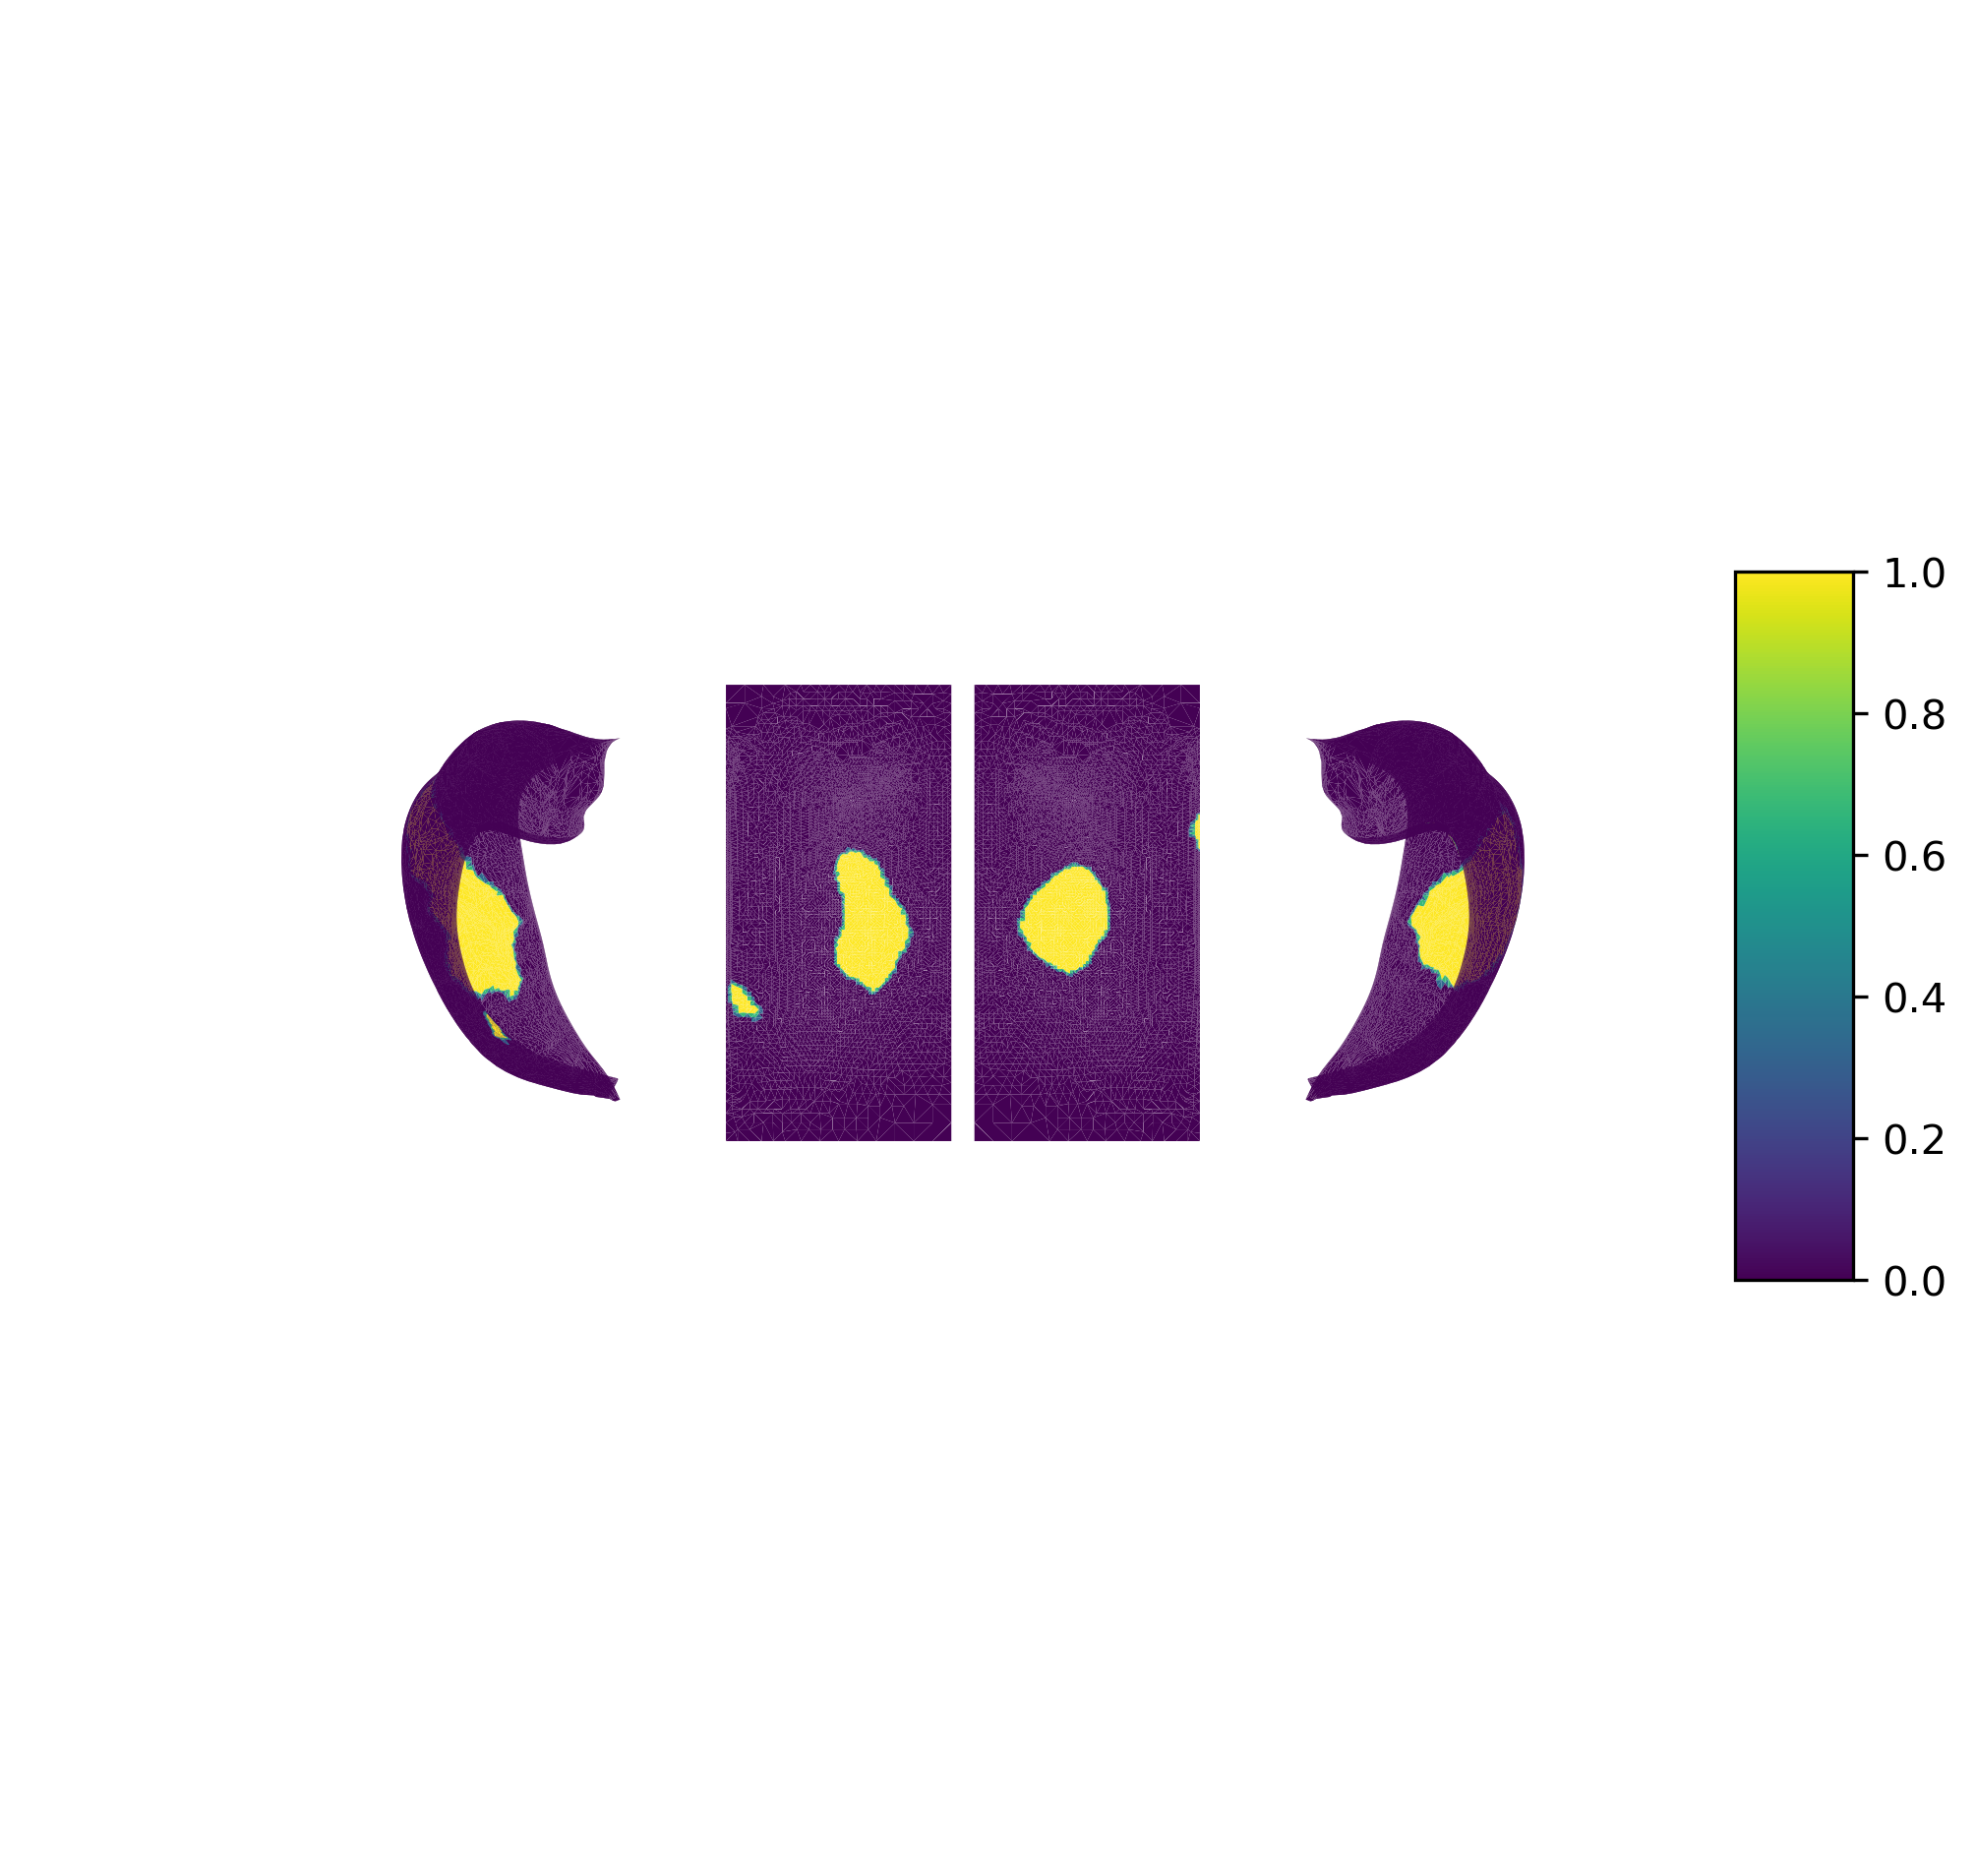

In [54]:
plot_surf(np.hstack([peakif_sigL,peakif_sigR]).T)

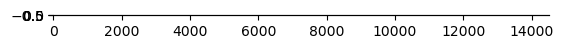

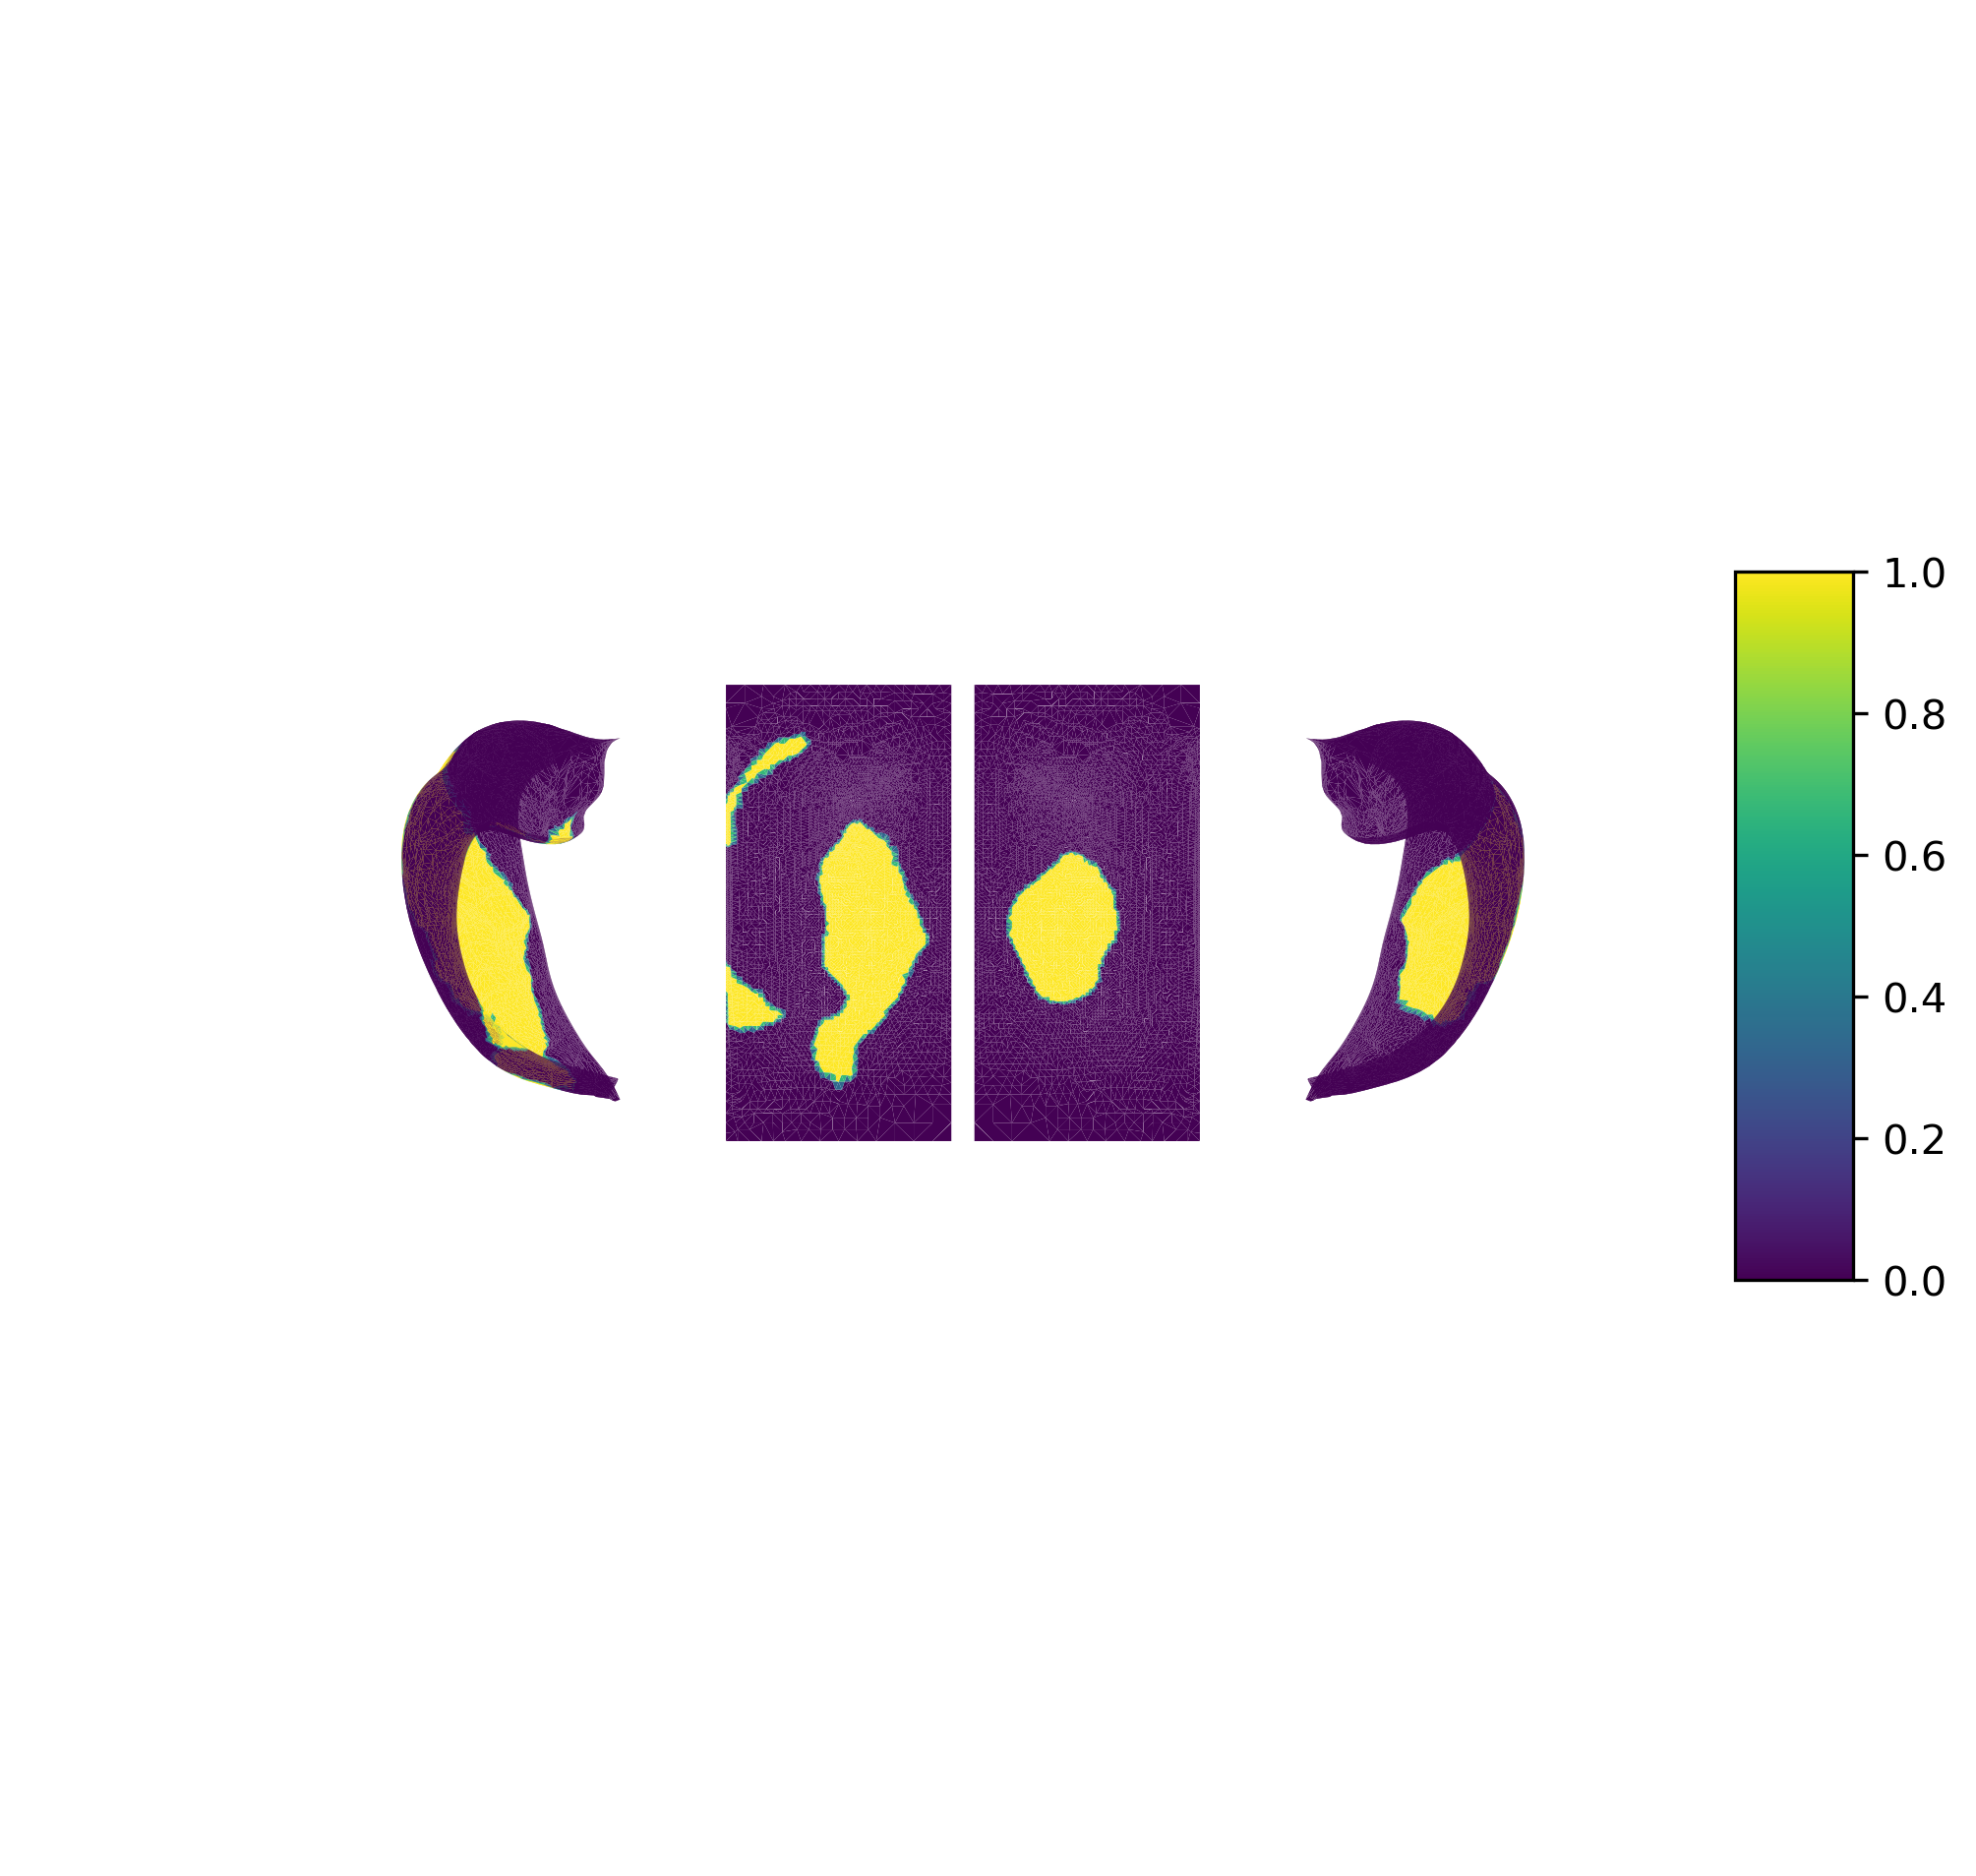

In [55]:
plot_surf(np.hstack([clusif_sigL,clusif_sigR]).T)